In [1]:
from sail.core import VMSetup, registersafeobj,login,connect,pushsafeobj,querydata,get_fns
from sail.data import RemoteDataFrame, Utils
from sail.algo import fdxgb

In [2]:
import json, requests
soPath = "/home/jjj/Development/Milestone3/EndPointTools/SafeObjectEditor/KPMG/safeobjects"
contractdict = [{"DigitalContractGuid":"{3243D05F-038A-4D59-99A2-45243646AAAD}"}, {"DigitalContractGuid":"{3292D7C5-4D0C-4D84-8B0F-07D13297E836}"}]
backendIP = "52.150.26.47"

registersafeobj(soPath)
print("[P]safe objects registered")

[P]safe objects registered


In [3]:
eosb = login("r@r.r", "SailPassword@123", 6200, backendIP)
print("[P]login success")

[P]login success


In [4]:
url = "https://"+backendIP+":6200/SAIL/VirtualMachineManager/GetRunningVMsIpAdresses?Eosb="+eosb

payloads = []
for item in contractdict:
    temp = json.dumps(item)
    payloads.append(temp)

headers = {
    'Content-Type': 'application/json'
}

ips = []
for payload in payloads:
    print(payload)
    response = requests.request("GET", url, headers=headers, data=payload, verify=False)
    response = response.json()
    print(response)
    for key in response['VirtualMachines']:
        ips.append(response['VirtualMachines'][key])
        print(ips)

{"DigitalContractGuid": "{3243D05F-038A-4D59-99A2-45243646AAAD}"}


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host '52.150.26.47'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


{'Status': 200.0, 'VirtualMachines': {'D61800E5B9684497BBF3E76ECDDF07FE': '20.124.39.30'}}
['20.124.39.30']
{"DigitalContractGuid": "{3292D7C5-4D0C-4D84-8B0F-07D13297E836}"}
{'Status': 200.0, 'VirtualMachines': {'ACA9F39B1DF04C269E78A20B6EC9F62D': '20.124.20.70'}}
['20.124.39.30', '20.124.20.70']


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host '52.150.26.47'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [5]:
vmids = []
for ip in ips:
    vmid = connect(ip, 3500)
    vmids.append(vmid)
print("[P]virtual machine connection to ip: {0} success".format(ip), flush=True)
    
fns = get_fns()
for vm in vmids:
    for key in fns:
        pushsafeobj(vm, fns[key])
print("[P]safe object pushed to virtual machines" , flush=True)

table = []
for vm in vmids:
    tableid = querydata(vm)
    table.append(tableid)
print("[P]obtain table ids", flush=True)

[P]virtual machine connection to ip: 20.124.20.70 success
[P]safe object pushed to virtual machines
[P]obtain table ids


In [6]:
table

[{'Telco churn split 2': '33C3B3C0FDC4CD4392D4D13C773BF551'},
 {'Telco churn split 1': '529E9FBA1A419249A59097C340B6B6D5'}]

In [7]:
u1 = Utils(vmids[0], fns)
u2 = Utils(vmids[1], fns)
df1 = u1.read_csv(table[0]['Telco churn split 2'])
df2 = u2.read_csv(table[1]['Telco churn split 1'])
dfs = [df1, df2]

In [8]:
dfs

['{31B9FD25-80AB-4EB8-867A-8A145FA1AE96}.5C37473C6D3443F49C03CAF0D746B997',
 '{DC208869-922A-498B-89C7-95FD19518E37}.5C37473C6D3443F49C03CAF0D746B997']

In [9]:
n=2
data1 = RemoteDataFrame(vmids[0], df1, fns)
data2 = RemoteDataFrame(vmids[1], df2, fns)
data = [data1, data2]

In [10]:
data

In [11]:
dtypes = data1.dtypes
type_dict = dict(dtypes)
cate_labels = [key for key in type_dict if type_dict[key] in ['bool', 'object']]
cate_labels.remove('phone number')

In [12]:
cols = []
cols.append(data1.columns)
cols.append(data2.columns)

In [13]:
y=[]
X=[]
n=2
for i in range(n):
    if 'phone number' in cols[i]:
        data[i].data_id = data[i].drop('phone number', axis = 1)
    data[i].data_id = data[i].label_encode(cate_labels)
    y.append(data[i]['churn'])
    X.append(data[i].drop('churn', axis = 1))

In [14]:
cols[0]

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [15]:
dim = len(cols[0])-2
fdxgbmod = fdxgb(vmids, params={'max_depth': 8 }, feature_num = dim)

In [16]:
y_new = []
for item in y:
    y_new.append(item.data_id)
y=y_new
y

['{95D167E1-937E-4B5E-89F8-E485993979D3}.048E16B349F8450694B1B30E0E49E6CE',
 '{3D856F7D-ABED-4B6C-969A-4EA16CCD890A}.048E16B349F8450694B1B30E0E49E6CE']

In [17]:
model = fdxgbmod.fit(X,y)

all_hashes has len 3332
all_counters has len 3332
1
Tree 1
Tree 2
Tree 3
Tree 4
Tree 5
Tree 6
Tree 7
Tree 8
Tree 9
Tree 10
Tree 11
Tree 12
Tree 13
Tree 14
Tree 15
Tree 16
Tree 17
Tree 18
Tree 19
Tree 20


In [18]:
results =  fdxgbmod.aucpr_score(model, X, y)

In [19]:
results

[[array([0.5       , 0.49948187, 0.5       , 0.50051921, 0.5010395 ,
         0.50156087, 0.50208333, 0.50260688, 0.50313152, 0.50365726,
         0.5041841 , 0.50471204, 0.50524109, 0.50577125, 0.50630252,
         0.50683491, 0.50736842, 0.50790306, 0.50843882, 0.50897571,
         0.50951374, 0.51005291, 0.51059322, 0.51113468, 0.51167728,
         0.51222104, 0.51276596, 0.51331203, 0.51385928, 0.51440768,
         0.51495726, 0.51550802, 0.51605996, 0.51661308, 0.51716738,
         0.51772288, 0.51827957, 0.51883746, 0.51939655, 0.51995685,
         0.52051836, 0.52108108, 0.52164502, 0.52221018, 0.52277657,
         0.52334419, 0.52391304, 0.52448313, 0.52505447, 0.52562704,
         0.52620087, 0.52677596, 0.5273523 , 0.5279299 , 0.52850877,
         0.52908891, 0.52967033, 0.53025303, 0.530837  , 0.53142227,
         0.53200883, 0.53259669, 0.53318584, 0.5337763 , 0.53436807,
         0.53496115, 0.53555556, 0.53615128, 0.53674833, 0.53734671,
         0.53794643, 0.53854749, 0

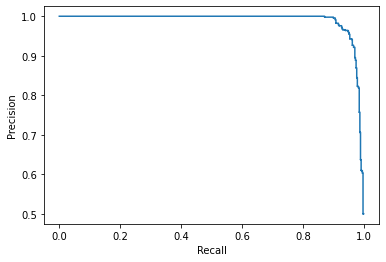

In [20]:
precision = results[0][0]
recall = results[0][1]
import numpy as np
#precision = np.append(precision, [1])
#print(precision)
#print(recall)
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

[<Figure size 800x910 with 2 Axes>, <Figure size 800x910 with 2 Axes>]

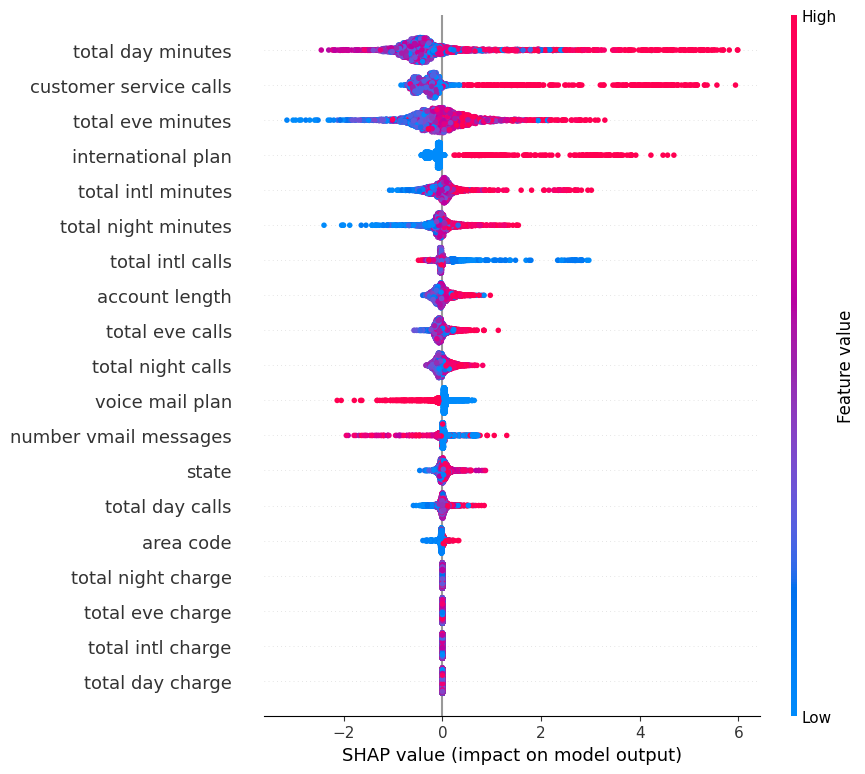

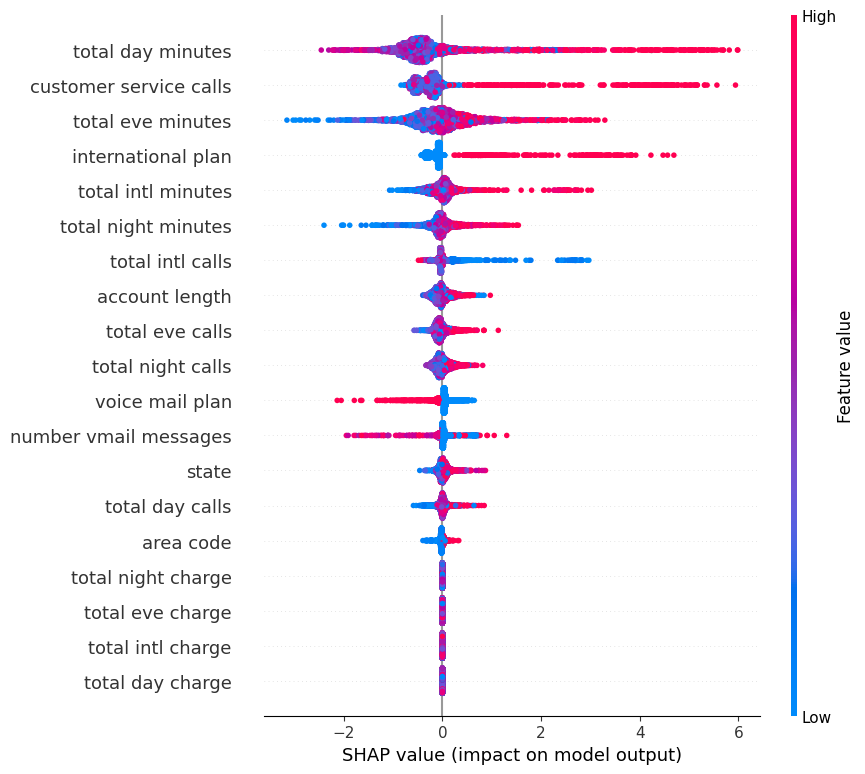

In [21]:
fdxgbmod.model = model
fdxgbmod.shap(X)